# PET deconvolution Exercise

1. Use STIR's `find_fwhm_in_image` utility to estimate the point spread function (PSF) using the point source measurement


2. Use this PSF to deconvolve the OSEM reconstruction with the Richardson-Lucy (RL) algorithm

3. RL can result in noise amplification. Use a CIL algorithm (we recommend PDHG) to do total variation (TV) regularised deconvolution


4. Image guidance can improve the accuracy of reconstructions/deconvolutions. Use the T1 MRI image as guidance for deconvolution by implementing a directional TV. 

5. Proximal algorithms such as TV are used when our objective function in non-differentiable. TV (and it's directional counterpart) can be smoothed and then used with gradient-based algorithms. Implement a preconditioned gradient descent algorithm using directional TV as a prior. Does this improve the convergence properties? Does smoothing the prior effect the solution?

6. What about when we have data from more than one modality? Can we use joint information to improve our resultant reconstructions? Implement a synergistic reconstruction and include Amyloid PET images in your deconvolution problem

In [46]:
# First we import the libraries we need

import numpy as np
import os
import subprocess
import re
import matplotlib.pyplot as plt

import sirf.STIR as pet

from cil.utilities.display import show2D
from cil.optimisation.operators import  BlurringOperator

import cil.optimisation.operators as op
import cil.optimisation.algorithms as alg
import cil.optimisation.functions as fn
import cil.framework as cil

msg = pet.MessageRedirector()

In [47]:
# some global variables to ensure we are using the same data everytime

noise_seed = 5
bw_seed = 1337

In [48]:
# Next we'll define a few functions that we'll use later on
# Some of these are redefined from the previous notebook and are included here for completeness
# You'll also be able to find them in helper_functions.py if you want to use them in other notebooks or scripts
# I haven't included any comments here as they can be found in helper_functions.py

def make_acquisition_model(template_sinogram, template_image, atten_image):

    acq_model = pet.AcquisitionModelUsingRayTracingMatrix()
    acq_model.set_num_tangential_LORs(10) 
    acq_asm = pet.AcquisitionModelUsingRayTracingMatrix()
    acq_asm.set_num_tangential_LORs(10)
    acq_model.set_acquisition_sensitivity(pet.AcquisitionSensitivityModel(atten_image, acq_asm))
    acq_model.set_up(template_sinogram,template_image)

    return acq_model

def find_fwhm_in_image(file_path):
    
    result = subprocess.run(['find_fwhm_in_image', file_path], capture_output=True, text=True)
    if result.returncode != 0:
        print("Error running command:", result.stderr)
        return None
    fwhm_regex = r"The resolution in (.*) axis is ([\d.]+)"
    matches = re.findall(fwhm_regex, result.stdout)
    fwhm_values = {axis: float(value) for axis, value in matches}

    return fwhm_values

def fwhm_to_sigma(fwhm):
    
    return fwhm / (2 * np.sqrt(2 * np.log(2)))

def psf(n, fwhm, voxel_size=(1, 1, 1)):

    sigma_voxels = [fwhm_to_sigma(fwhm[i]) / voxel_size[i] for i in range(3)]
    axes = [np.linspace(-(n - 1) / 2., (n - 1) / 2., n) for i in range(3)]
    gauss = [np.exp(-0.5 * np.square(ax) / np.square(sigma_voxels[i])) for i, ax in enumerate(axes)]
    kernel_3d = np.outer(gauss[0], gauss[1]).reshape(n, n, 1) * gauss[2].reshape(1, 1, n)
    return kernel_3d / np.sum(kernel_3d)

In [49]:
# Let's load the images we'll use in this notebook that we generated in the previous notebook

image_list = ['PET', 'T1', 'uMap']
image_dict = {}
for image in image_list:
    image_dict[image] = pet.ImageData(os.path.join('data', f'{image}_b{bw_seed}.hv'))
image_dict['OSEM'] = pet.ImageData(os.path.join('data', f'OSEM_b{bw_seed}_n{noise_seed}.hv'))
image_dict['OSEM_psf'] = pet.ImageData(os.path.join('data', f'OSEM_psf_n{noise_seed}.hv'))

In [50]:
# We'll now use a STIR utility to find the FWHM of the PSF in the point source reconstruction that we generated in the previous notebook

fwhm = list(find_fwhm_in_image(os.path.join('data', f'OSEM_psf_n{noise_seed}.hv')).values())
print(f'FWHM: {fwhm}')
PSF=psf(5, fwhm=fwhm, voxel_size=image_dict['OSEM'].voxel_sizes())
convolve=BlurringOperator(PSF, image_dict['PET'])

FWHM: [7.72017, 7.74318, 7.39883]


## Richardson-Lucy algorithm

If you understand MLEM, you understand RL. The RL update for image $u$ is:

$$ x^{(n+1)} = x^{(n)} \odot C^\dagger \ast \frac{x_j^{(0)}}{C \ast x^{(n)}} $$

where we $C$ is our convolution kernel and $\odot$, $\ast$ denote the hadamard (element-wise) product and convolutional operators. We take a ratio of our OSEM image (which is our initial estimate) and our current estimate convolved with the point spread function that we estimated above. We then find the adjoint of this convolution and then multiply the result of this by the current image estimate

In [51]:
# Here is the above in code

def RL(initial, convolution, iterations, eta=1e-6):
    ''' Richardson-Lucy algorithm for deconvolution'''
    
    objective_values = [] # We'll store the objective values at each iteration here

    current_estimate = initial.clone() # We'll update this estimate at each iteration
    convolved_estimate = convolution.direct(current_estimate) # We'll store the convolved estimate here

    for i in range(iterations):
        
        current_estimate*= convolution.adjoint(initial/(convolved_estimate+eta)) # Our update is here
        
        convolved_estimate = convolution.direct(current_estimate) # update the convolved estimate
        objective_values.append(convolved_estimate.sum() - (initial * (convolved_estimate+eta).log()).sum()) # calculate the objective value

        print(f"Iteration: {i}, Objective: {objective_values[-1]}", end = '\r')

    return current_estimate, objective_values

Let's now run this algorithm for 5, 20 and then 50 iterations to see how it performs

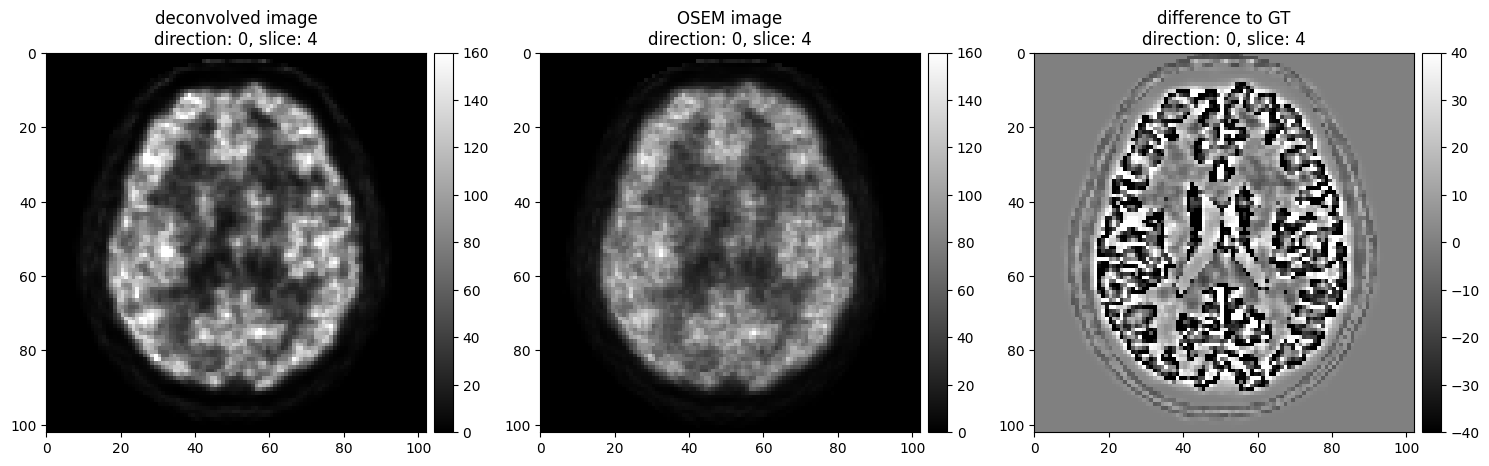

Text(0, 0.5, 'Objective Function Value')

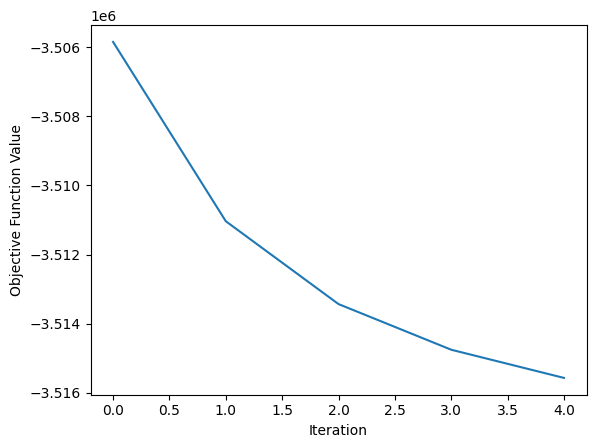

In [52]:
deconvolved_5iter, obj_5iter = RL(image_dict['OSEM'], convolve, 5)

show2D([deconvolved_5iter, image_dict['OSEM'], deconvolved_5iter-image_dict['PET']], 
       title = ['deconvolved image', 'OSEM image', 'difference to GT'], 
       origin = 'upper', num_cols = 3, fix_range=[(0,160), (0,160), (-40,40)],)

plt.plot(obj_5iter)   
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

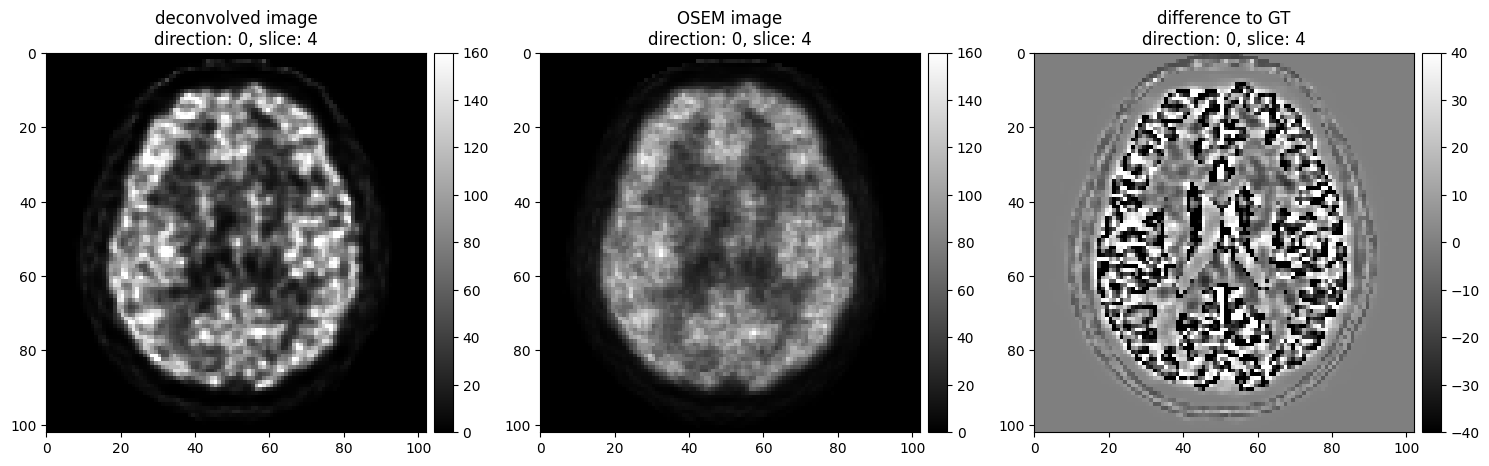

Text(0, 0.5, 'Objective Function Value')

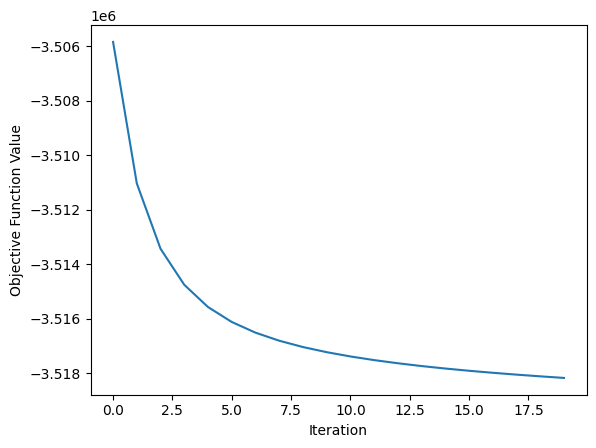

In [53]:
deconvolved_20iter, obj_20iter = RL(image_dict['OSEM'], convolve, 20)

show2D([deconvolved_20iter, image_dict['OSEM'], deconvolved_20iter-image_dict['PET']], 
       title = ['deconvolved image', 'OSEM image', 'difference to GT'], 
       origin = 'upper', num_cols = 3, fix_range=[(0,160), (0,160), (-40,40)],)

plt.plot(obj_20iter)   
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

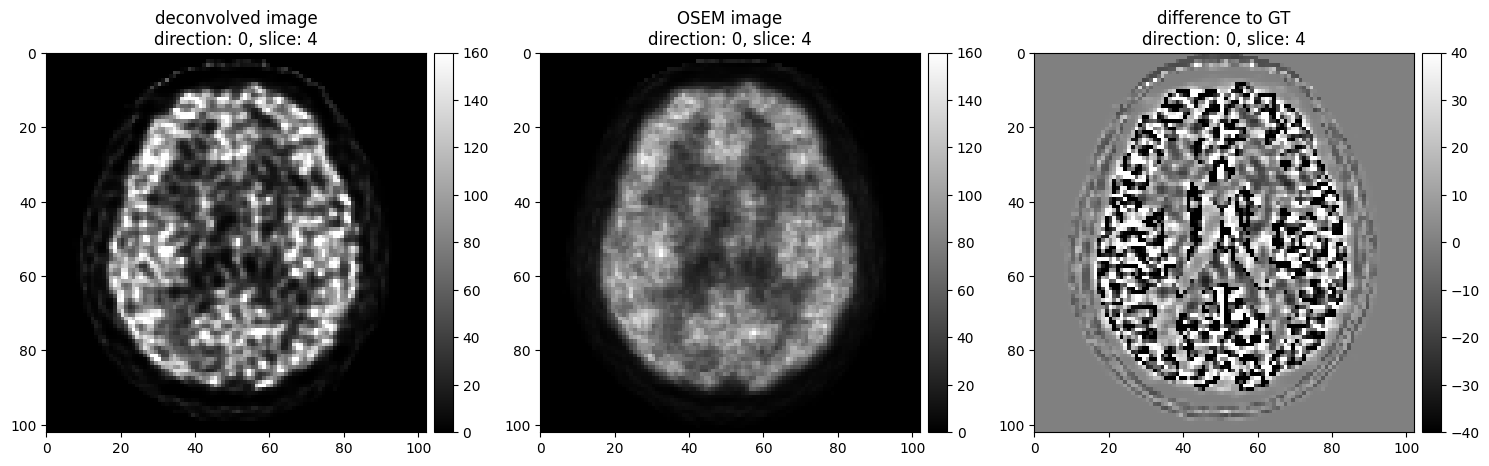

Text(0, 0.5, 'Objective Function Value')

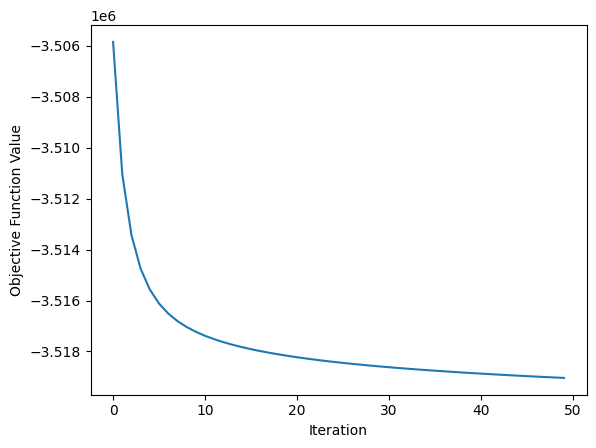

In [54]:
deconvolved_50iter, obj_50iter = RL(image_dict['OSEM'], convolve, 50)

show2D([deconvolved_50iter, image_dict['OSEM'], deconvolved_50iter-image_dict['PET']], 
       title = ['deconvolved image', 'OSEM image', 'difference to GT'], 
       origin = 'upper', num_cols = 3, fix_range=[(0,160), (0,160), (-40,40)],)

plt.plot(obj_50iter)   
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

Text(0.5, 1.0, 'Comparison of profiles at y=50')

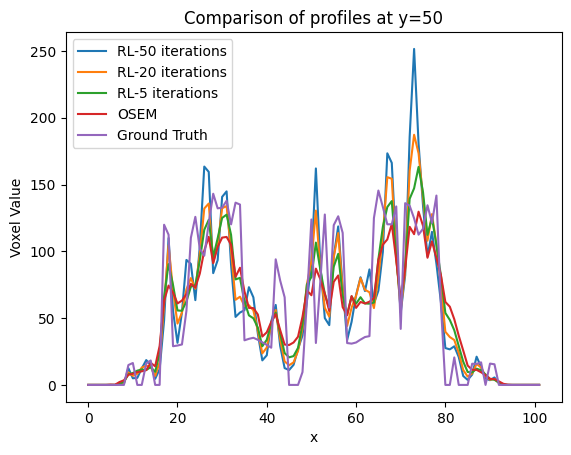

In [55]:
plt.plot(deconvolved_50iter.as_array()[4][50], label = 'RL-50 iterations')
plt.plot(deconvolved_20iter.as_array()[4][50], label = 'RL-20 iterations')
plt.plot(deconvolved_5iter.as_array()[4][50], label = 'RL-5 iterations')
plt.plot(image_dict['OSEM'].as_array()[4][50], label = 'OSEM')
plt.plot(image_dict['PET'].as_array()[4][50], label = 'Ground Truth')
plt.legend()
plt.xlabel('x')
plt.ylabel('Voxel Value')
plt.title('Comparison of profiles at y=50')


We have achieved some reasonable image sharpening but can see that, even after only 50 iterations, we're starting to get a lot of noise amplification. Fortunately we know how to fix that... regularisation!

## Regularised Deconvolution

In the second half of this notebook, we'll look at a few techniques to suppress the noise amplification that we have seen with RL.

Firstly, we'll lay out a quick skeleton for a reconstruction using PDHG of total variation (TV) regularised deconvolution. If you need some help, there's a good example notebook [here](https://github.com/TomographicImaging/CIL-Demos/blob/main/demos/2_Iterative/03_PDHG.ipynb)

### Total Variation regularised deconvolution

For a deconvolution with PET (approximately Poisson noise) OSEM images, we construct a Bayesian log objective function:

$$ \Phi(\mathbf{x}) = \sum_j \; \Delta_{KL}((C \ast x )_j;\; \bar{x}_{j}) + \alpha \Psi(x_j) $$

where we have a data fidelity function $\Delta_{KL}$ parameterised by our OSEM reconstruction $\bar{x}$ and a regularisation function $\Psi$. We sum up over all voxels $j$ to get our objective function value, which we want to minimise in this case. $\alpha$ is a parameter to control the strength of regularisation. For Poisson noise, we need to use the negative Poisson log-likelihood. This is the same (to a constant) as the Kullback-Leibler divergence (KL), which is implemented in the Core Imaging Library (CIL) and with which SIRF's functionality has been designed.

Total variation in as edge preserving prior orignally formulated [here](https://doi.org/10.1016/0167-2789(92)90242-F) for noise removal. There are a number of formulations but the one we'll use today is

$$ \Psi(x_j)_{TV} := |\nabla x_j|_2$$

Or the $l$-2 norm of the finite difference (we'll use the CIL default which is forward difference) operator, $\nabla$ applied to our current image estimate. There is a wealth of literature on the TV prior for denoising, PET reconstruction and denoising so we won't got into any further detail here, but please do have a quick search on Scholar.

## PDHG

You don't need to understand this next part in order to complete the notebook but if you find it interesting, please do have a read:

Total variation is non-smooth, which means that it is not continuously differentiable. Luckily for us, there are a class of algorithms known as proximal algorithms that can handle non-smooth functions. We can minimise our objective function by applying one or more proximal mappings, defined for a function $\mathcal{F}$

$$ \text{prox}_{\lambda \mathcal{F}}(x) := \underset{x^\prime}{\text{arg min }} \mathcal{F}(x^\prime) + \frac{1}{2 \lambda}|x - x^\prime|_2^2 $$

where $\lambda$ controls the size of the step we take (akin to the step size in gradient descent). Unfortunately for us, neither the KL divergence when defined, as we have, with an operator nor TV have an explicit solution to the proximal mapping. Fortunately, their convex conjugates (also known as dual functions) do. We won't go into what a convex conjugate is here, but please see [here](https://remilepriol.github.io/dualityviz/) for what I think is a nice geometric visualisation of and [here](https://ocw.mit.edu/courses/6-253-convex-analysis-and-optimization-spring-2012/resources/mit6_253s12_lec01/) for some very good lecture notes on convex optimisation.

The Primal-Dual Hybird Gradient algorithm (first published [here](https://link.springer.com/article/10.1007/s10851-010-0251-1)) uses this concept of duality (specifically strong duality) to optimise problems such as ours. We refer you again to [this](https://github.com/TomographicImaging/CIL-Demos/blob/main/demos/2_Iterative/03_PDHG.ipynb) notebook for a brief description of proximal operators and PDHG and how to use them in CIL.

In [56]:
# OK - let's set up a few bits and pieces for the optimisation problem

alpha = 0.02 # This is by no means optimal, but it's a good starting point

f1 = # We'll define the data fidelity term here
f2 = alpha * # We'll define the regularisation term here

f = fn.BlockFunction(f1, f2)

g = fn.IndicatorBox(0) # This ensures non-negativity which is important for PET images

grad = # We'll define the gradient operator here

K = op.BlockOperator(convolve, grad)

SyntaxError: invalid syntax (1002905142.py, line 5)

In [ ]:
# Define the step sizes for the primal and dual proximal mappings
# These are by no means optimal, but they do guarantee convergence
normK = K.norm()
gamma = 1
sigma = 0.99*gamma/normK
tau = 0.99/(normK*gamma)

In [ ]:
# TODO: This monkey patching is a temporary solution to a bug in CIL - possibly not needed in the future

def update_previous_solution(self):
    tmp = self.x_old
    self.x_old = self.x
    self.x = tmp

alg.PDHG.update_previous_solution = update_previous_solution

In [ ]:
pdhg = # We'll define the PDHG algorithm here


In [ ]:
pdhg.run(verbose=1)


In [62]:
# %load './snippets/pdhg_setup.py'


In [ ]:
# Let's have a look how we did...

show2D([pdhg.solution, image_dict['OSEM'], pdhg.solution-image_dict['PET']],
         title = ['deconvolved image', 'OSEM image', 'difference to GT'], 
         origin = 'upper', num_cols = 3, fix_range=[(0,160), (0,160), (-40,40)],)

plt.plot(pdhg.objective)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

## Image guidance

OK, so this is all well and good but we have this beautiful MRI image just sitting there. How can we improve our reconstruction by utilising this high resolution image as guidance?

We can use the directional total variation regulariser

$$\Psi_{dTV}:= \sum_j|D_i\nabla x_j|_2$$

 where the sum is over the pixels $j$ and where $D$ is a weighting vector filed on the gradient in $x$ dependent on the normalised gradient, $\zeta$,  of the reference image, $\nu$ so 
$$D=I-\zeta \zeta^T$$
and $$\zeta = -\dfrac{\nabla \nu }{\sqrt{\eta^2+|\nabla\nu|^2}}$$ where $0<\eta<<\|\nabla\nu\|$.


We can see that if $\nabla x= \gamma \nabla \nu$ then

 $$D\nabla x = \gamma D\nabla \nu= \gamma (I-\zeta \zeta^T)\nabla \nu= \gamma \left(\nabla \nu -\dfrac{\nabla \nu }{\sqrt{\eta^2+|\nabla\nu|^2}} \dfrac{\nabla \nu^T }{\sqrt{\eta^2+|\nabla\nu|^2}} \nabla \nu \right)=\gamma\nabla \nu \left(1-(1+\mathcal{O}(\frac{\eta^2}{\|\nabla\nu\|^2}) )\right) \approx 0.$$

We can also see if the gradient of the reconstructed image and the reference image are perpendicular, $\nabla x^T\nabla \nu=0$, then

$$D\nabla x (I-\zeta \zeta^T)\nabla x= \nabla \nu - \dfrac{\nabla \nu }{\sqrt{\eta^2+|\nabla\nu|^2}} \dfrac{\nabla \nu^T }{\sqrt{\eta^2+|\nabla\nu|^2}} \nabla x =\nabla \nu $$

 and is non-zero. 

This regulariser encourages the gradient of the reconstructed image to be equal to parallel to the gradient of the reference image. 

In [ ]:
class DirectionalOperator(op.LinearOperator):

    def __init__(self, anatomical_gradient, gamma = 1, eta=1e-6):

        self.anatomical_gradient = anatomical_gradient
        geometry = cil.BlockGeometry(*[x for x in anatomical_gradient.containers])
        self.tmp = self.anatomical_gradient.containers[0].clone()

        self.gamma = gamma

        self.xi = # We'll define the xi operator here

        super(DirectionalOperator, self).__init__(domain_geometry=geometry,
                                       range_geometry=geometry,)
        
    def direct(self, x, out=None):

        # We'll define the direct operator here
    
    def adjoint(self, x, out=None):
        
        # We'll define the adjoint operator here
    
    def dot(self, x, y):
        ''' This function calculates the elementwise dot product of two images'''
        self.tmp.fill(0)
        for el_x, el_y in zip(x.containers, y.containers):
            self.tmp += el_x * el_y
        return self.tmp
    

In [ ]:
# Define your operators and functions here

In [ ]:
# %load './snippets/DirectionalOperator.py'

In [ ]:
normK = K.norm()
gamma = 1
sigma = gamma*0.99/normK
tau = 0.99/(normK*gamma)

In [ ]:
pdhg_dtv = # We'll define the PDHG algorithm here

pdhg_dtv.run(verbose=1)

In [ ]:
# %load './snippets/pdhg_dtv_setup.py'

In [ ]:
# let's have a look how we did...

show2D([pdhg_dtv.solution, image_dict['OSEM'], pdhg_dtv.solution-image_dict['PET']],    
         title = ['deconvolved image', 'OSEM image', 'difference to GT'], 
         origin = 'upper', num_cols = 3, fix_range=[(0,160), (0,160), (-40,40)],)


plt.plot(pdhg_dtv.objective)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

PDHG means that we can optimise non-smooth problems but can be slow. There are many ways of improving this convergence speeds (stochastic subsets, hyperparameter optimisation, non-static step-sizes, strong convexity) but we'll go for a much easier solution here - we'll make the TV priors smooth. We can do this by adding a small parameter to ensure that there is no undefined gradient at $x=0$

$$ \Psi(x_j)_{TV} := |\nabla x_j + \eta^2|_2$$

Now we can use gradient based algorithms. We'll let you use your imagination here. There are loads of algiorithms in CIL and many many more in literature. If you're struggling, there's an implementation of a preconditioned gradient descent algorithm in the solution notebook

In [ ]:
# %load './snippets/MAPRL.py'

In [ ]:
# %load './snippets/run_maprl.py'

## Synergistic Reconstruction

OK so we've used image guidance to improve our reconstructions but what about truly synergistic recosntructions with multiple modalities? First let's generate some different data. Run the cell below to generate and load some OSEM reconstructions of amyloid PET using the same patient but with different tracer dynamics and noise statistics

In [ ]:
# run python3 amyloid.py to generate an additional OSEM image

subprocess.run(['python3', 'amyloid.py', f'--bw_seed={bw_seed}', f'--noise_seed={noise_seed+1}'])

image_dict['OSEM_amyloid'] = pet.ImageData(os.path.join('data', f'OSEM_amyloid_b{bw_seed}_n{noise_seed+1}.hv'))
image_dict['PET_amyloid'] = pet.ImageData(os.path.join('data', f'PET_amyloid_b{bw_seed}.hv'))

And then use what you've learned to do some Synergistic reconstructions. This will be a lot harder than the single-modality stuff that we've done so far. You'll need to read some of the CIL [documentation](https://tomographicimaging.github.io/CIL/nightly/) - especially the section on the block framework. Choose PDHG or something completely different! Again, there's a gradient-based solution in the solution notebook using smooth joint total variation but please only use this as a last resort. Ask us questions & get reading.

You'll need a synergistic function as well as two separate data fidelity functions for the FDG PET and Amyloid PET.

In [ ]:
# monkey patching TODO: remove in the future when CIL is updated
# I found these changes to CIL to be useful for synergistic reconstruction but you may not. I'll leave them in here just in case

def allocate(self, value=0):
    ''' So we can create an empty BlockDataContainer '''
    out = self.clone()
    for el in out.containers:
        el.fill(value)
    return out

cil.BlockDataContainer.allocate = allocate
    
def new(cls, *args, **kwargs):
    ''' So that a shape=(1,1) BlockDataContainer is just a DataContainer'''
    instance = super(cil.BlockDataContainer, cls).__new__(cls) 
    instance.__init__(*args, **kwargs)

    if getattr(instance, 'shape', None) == (1, 1):
        return cls.containers[0] 
    return instance

cil.BlockDataContainer.__new__ = staticmethod(new)

class bdc_FOV_filter(pet.TruncateToCylinderProcessor):
    ''' 
    A class to apply the FOV filter to each element of a BlockDataContainer 
    An FOV filter is a cylindrical filter that removes data outside of the FOV
    It's useful to remove edge effects in PET image
    '''
    def apply(self, bdc):
        for el in bdc.containers:
            super().apply(el)

In [ ]:
# And away we go...

In [ ]:
# %load './snippets/MergeBlockDataContainer.py'

In [ ]:
# %load './snippets/run_synergistic_maprl.py'

In [ ]:
# %load './snippets/BlockIndicator.py'

In [ ]:
# %load './snippets/run_spdhg.py'